# Brief Explanation

## 1. Data Cleaning & Feature Engineering using Pyspark 

For the original data, we mainly built four kinds of new features:  
1) Date time difference between all datetime object    
2) booking rate for each "user, destination" pair  
3) Reduction on destination latent features using PCA  
4) 'Month' feature of search datetime, check_in_date, check_out_date (Because hotels tend to change their cluster seasonally. To capture this variation, we also included the month of each record)

## 2. Evaluation Metric(MAP@5)

$MAP@5 = \frac{1}{|U|}\sum_{u=1}^{|U|}\sum_{k=1}^{min(5,n)}P(k)$ (Mean Average Precision@5)  
where |U| is the number of user events, P(k) is the precision at cutoff k, n is the number
of predicted hotel clusters

## 3. Machine Learning

There are two ways of looking at this problem. One is as a multi-class classification problem. After predicting the probability of each class, we return the top 5 hotel cluster. The other one is as a ranking problem. In this case, we are doing a pair-wise ranking problem for each query.

For the multi-class classification case, we mainly used three models: xgboost, lightgbm and random forest. Their map@5 are respectively, 0.27, 0.05, 0.17 on the test data. For the ranking problem, we bursted each booking to 100 rows to do pair-wise ranking using xgboost. It achieves 0.05 MAP@5. The reason why ranking is bad is because most features we used in the bursted data is same among each query. To be specific, we use mainly the fixed features of each query's user and destination except booking_rate and the features regarding each hotel cluster. So there is not much variance in each query. We have checked the winning solution of this competition. Besides the features wee have used, other features he used mainly consisits of two parts: 1) Distance Matric completion 2) Factorization Machines for each of the 100 hotel clusters on all the categorical features. But we cannot reproduce the result beacuse of the huge cost in memory. Some of the categorical features have over 10000 distinct values. Our computers cannot handle that much data. Actually, the 1st placce winner's computer specification is a dual socket E5-2699v3 with ~700GB ram. More details can be checked here [Expedia 1st Solution](https://www.kaggle.com/c/expedia-hotel-recommendations/discussion/21607).

*Baseline of the result*: We also have checked other people's results on Kaggle. The typical map@5 that can be achieved using xgboost is around 0.27-0.3, 0.17-0.19 for random forest. So our implementation is right. There is also a data leakage solution which can increased the result to around 0.5. And our result is also 0.5. After doing averging bagging / stacking of the models, the result can be higher. In conclusion, our implementations are right.

To improve the tuning parameters speed, we used hyperopt to tune instead of GridSearch/RandomSearch of sklearn. It can achieve comparable result with much faster speed. One thing needs to be mentioned is beacause the data is very large, using CPU version of xgboost takes 8 hours to tune the parameters. So to speed up the tuning, we also tried GPU version of xgboost, which takes only 2 hours. 

## 1. Data Visualization & Cleaning & Feature Engineering using Pyspark 

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import hp, tpe, STATUS_OK, Trials, fmin
%matplotlib inline

### Data Visualization

In [6]:
train = pd.read_csv("D:/Data/Expedia/train.csv", parse_dates=['date_time'], nrows=10000000)

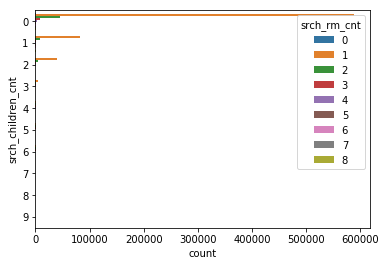

In [7]:
# Different category count on 'srch_children_cnt'
mask = train.is_booking == True
trainm = train[mask]
b1 = trainm[['srch_adults_cnt','srch_children_cnt','srch_rm_cnt']]
sns.countplot(y='srch_children_cnt', hue='srch_rm_cnt', data=trainm)

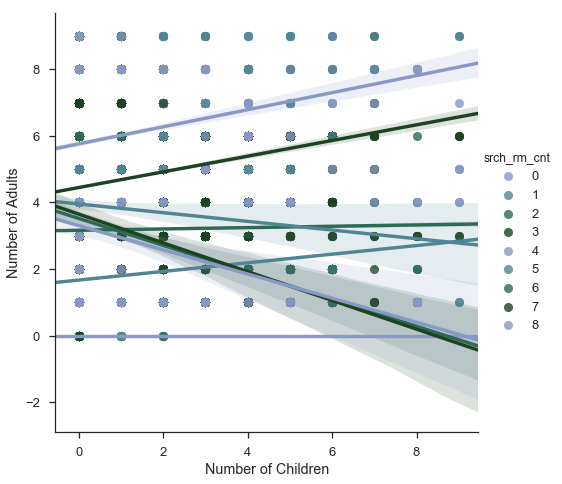

In [8]:
# Linear regression plot on "Number of Children" VS "Number of Adults"
sns.set(style="ticks", context="talk")

pal = sns.cubehelix_palette(4, 1.5, .75, light=.6, dark=.2)

g = sns.lmplot(x="srch_children_cnt", y="srch_adults_cnt", hue="srch_rm_cnt", data=trainm,
               palette=pal, size=7)

g.set_axis_labels("Number of Children", "Number of Adults")

### Data Processing

In [2]:
from pyspark import SparkConf, SparkContext
conf = (SparkConf()
         .setMaster("local")
         .setAppName("My app")
         .set("spark.driver.memory", "8g"))
sc = SparkContext(conf = conf)

In [3]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
sqlContext = SQLContext(sc)

In [4]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

In [5]:
start = time()
home_dir = '/home/krystalu/Data/Expedia/'
train = sqlContext.read.load(home_dir + 'train.csv', 
                             format='com.databricks.spark.csv', 
                             header='true', 
                             inferSchema='true')

test = sqlContext.read.load(home_dir + 'test.csv', 
                            format='com.databricks.spark.csv', 
                            header='true', 
                            inferSchema='true')

print 'Read Time: {} mins'.format((time()-start)/60)

Read Time: 7.73307231665 mins


In [6]:
# Original train data schema
train.printSchema()

root
 |-- date_time: timestamp (nullable = true)
 |-- site_name: integer (nullable = true)
 |-- posa_continent: integer (nullable = true)
 |-- user_location_country: integer (nullable = true)
 |-- user_location_region: integer (nullable = true)
 |-- user_location_city: integer (nullable = true)
 |-- orig_destination_distance: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- is_mobile: integer (nullable = true)
 |-- is_package: integer (nullable = true)
 |-- channel: integer (nullable = true)
 |-- srch_ci: timestamp (nullable = true)
 |-- srch_co: timestamp (nullable = true)
 |-- srch_adults_cnt: integer (nullable = true)
 |-- srch_children_cnt: integer (nullable = true)
 |-- srch_rm_cnt: integer (nullable = true)
 |-- srch_destination_id: integer (nullable = true)
 |-- srch_destination_type_id: integer (nullable = true)
 |-- is_booking: integer (nullable = true)
 |-- cnt: integer (nullable = true)
 |-- hotel_continent: integer (nullable = true)
 |-- hotel_country: 

In [7]:
# Diff of train & test columns
set(train.columns) - set(test.columns)

{'cnt', 'hotel_cluster', 'is_booking'}

In [9]:
# Booking/Non-booking ratio
df1 = train.where(F.col('is_booking')==1)
booking_num = df1.count()
df2 = train.where(F.col('is_booking')==0)
non_booking_num = df2.count()
print 'Booking/Non-booking ratio: {}%'.format(booking_num/non_booking_num*100)
del df1, df2

Booking/Non-booking ratio: 8.65511283661%


### Features to build:
1. Data time difference among date time features
2. booking rate for each "user, dest" pair
3. PCA for latent features
4. "month" of 'date_time', 'ci', 'co'

In [8]:
# Check whether user_id of test is a subset of train's user_id and vice versa
d1 = pd.read_csv('train.csv',usecols=['user_id'])
d2 = pd.read_csv('test.csv',usecols=['user_id']) 
print set(d2.user_id).issubset(d1.user_id)
print set(d1.user_id).issubset(d2.user_id)

# Delete users with no booking
diff = list(set(d1.user_id) - set(d2.user_id))
train = train.filter(~F.col('user_id').isin(diff))
del d1, d2

True
False


In [9]:
# booking rate of each (user, destination) pair
res = train.groupBy("user_id", "srch_destination_id") \
           .agg(F.avg((F.col("is_booking") == 1) \
           .cast("integer")).alias('booking_rate'))
train = train.join(res, ["user_id", "srch_destination_id"], 'outer')

In [10]:
# Using only the "booking" data as train data. 
# Because if a user didn't book, then we consider he/she is not interested.
train = train.where(F.col('is_booking') == 1)

In [11]:
# Find the duration among "srch_co", "srch_ci", "date_time"
train = train.withColumn("ci_co_duration", F.datediff(F.to_date("srch_co"), F.to_date("srch_ci"))) \
             .withColumn('ci_dt_duration', F.datediff(F.to_date("srch_ci"), F.to_date("date_time"))) \
             .withColumn('co_dt_duration', F.datediff(F.to_date("srch_co"), F.to_date("date_time")))

In [12]:
# As per the details provided by Expedia on the competition page, 
# hotels tend to change their cluster seasonally. To capture this variation, 
# we also included the month of each record
train = train.withColumn("ci_month", F.month(train.srch_ci)) \
            .withColumn("co_month", F.month(train.srch_co)) \
            .withColumn("dt_month", F.month(train.date_time))

In [13]:
# Processed train schema
train.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- srch_destination_id: integer (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- site_name: integer (nullable = true)
 |-- posa_continent: integer (nullable = true)
 |-- user_location_country: integer (nullable = true)
 |-- user_location_region: integer (nullable = true)
 |-- user_location_city: integer (nullable = true)
 |-- orig_destination_distance: double (nullable = true)
 |-- is_mobile: integer (nullable = true)
 |-- is_package: integer (nullable = true)
 |-- channel: integer (nullable = true)
 |-- srch_ci: timestamp (nullable = true)
 |-- srch_co: timestamp (nullable = true)
 |-- srch_adults_cnt: integer (nullable = true)
 |-- srch_children_cnt: integer (nullable = true)
 |-- srch_rm_cnt: integer (nullable = true)
 |-- srch_destination_type_id: integer (nullable = true)
 |-- is_booking: integer (nullable = true)
 |-- cnt: integer (nullable = true)
 |-- hotel_continent: integer (nullable = true)
 |-- hotel_country: 

In [14]:
# Write the processed file to local
train.coalesce(1).write.csv('train_v1.csv',header='true')

In [3]:
# Since destinations variables are measured on the same scale, so we don't need to normalize for PCA.
dest = pd.read_csv('G:/expedia/destinations.csv')
dest_id = dest['srch_destination_id']
dest.drop('srch_destination_id', axis=1, inplace=True)

In [4]:
# Reconstruction error VS n_components
n_comp = range(121)
errors = []
for item in n_comp:
    pca = PCA(n_components=item)
    dest_pca = pca.fit_transform(dest)
    dest_proj = pca.inverse_transform(dest_pca)
    # MSE Error
    loss = np.mean(np.mean(((dest - dest_proj)**2)))
    errors.append(loss)

Text(0,0.5,u'Reconstruct Error')

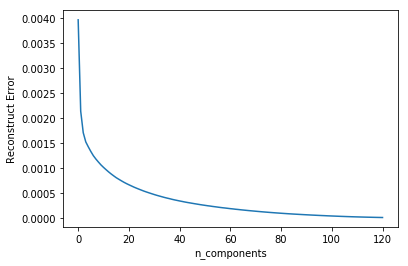

In [5]:
plt.plot(n_comp, errors, '-')
plt.xlabel("n_components")
plt.ylabel("Reconstruct Error")

In [4]:
"""
Since the first 20 components have explained 83% of the total variance, it's enough.
"""
pca_20 = PCA(n_components=20)
pca_20.fit(dest)
print 'n_components=20 cummulative explained varaiance ratio: {}' \
        .format(np.cumsum(pca_20.explained_variance_ratio_)[-1])

n_components=20 cummulative explained varaiance ratio: 0.831960789047


In [5]:
dest_trans = pca_20.transform(dest)

In [6]:
dest_df = pd.DataFrame(dest_trans)
dest_df['srch_destination_id'] = dest_id
dest_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,srch_destination_id
0,-0.044268,0.169419,0.032522,-0.014270,-0.069688,-0.012307,-0.169771,0.173699,-0.201270,0.083227,...,0.043057,0.049437,0.048940,0.095843,-0.113653,-0.090336,0.030543,-0.047528,-0.118431,0
1,-0.440761,0.077405,-0.091572,-0.020229,0.013213,0.029696,-0.013491,0.007494,-0.031695,-0.028785,...,-0.001340,-0.023608,0.037209,-0.009620,0.036719,0.038193,0.012115,0.022869,0.001225,1
2,0.001033,0.020677,0.012109,0.134141,0.142033,0.088819,-0.143692,0.089174,0.172447,-0.038028,...,0.031662,-0.061882,-0.040596,-0.081329,-0.025798,-0.063630,0.000149,0.030590,-0.028522,2
3,-0.480467,-0.040345,-0.019320,-0.040100,-0.027393,0.017351,0.029537,0.033168,-0.026522,0.042434,...,0.024484,0.001669,-0.000199,0.022460,-0.002101,0.004284,0.017831,0.000826,-0.016131,3
4,-0.207253,-0.042694,-0.011744,-0.017521,-0.019865,-0.037971,-0.036595,-0.004304,-0.007717,0.010025,...,-0.022285,0.005150,-0.000260,0.034593,-0.070210,-0.026219,-0.031342,-0.014211,0.021995,4


In [7]:
# Read train_v1, latent features file and merge them
train = pd.read_csv('G:/expedia/train_v1.csv')
train = pd.merge(train, dest_df, on = 'srch_destination_id', how = 'left')
train.head()

,user_id,srch_destination_id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,...,10,11,12,13,14,15,16,17,18,19
0,46,27256,2014-10-21T21:47:51.000-04:00,2,3,66,258,4687,307.9863,0,...,0.215402,-0.280355,0.191237,-0.082040,-0.057577,0.118205,0.020312,0.024700,-0.093515,-0.050814
1,257,8266,2014-12-23T07:45:24.000-05:00,2,3,66,447,25977,1415.9458,0,...,-0.039101,0.098384,0.088709,-0.010701,-0.031861,-0.012642,-0.095285,-0.019206,-0.036384,0.121745
2,327,24192,2014-09-30T11:54:45.000-04:00,2,3,66,356,22202,485.5027,0,...,-0.008414,0.029675,0.057691,0.072057,0.002104,-0.096640,-0.016063,-0.007673,-0.037920,-0.039683
3,449,25698,2014-10-10T14:50:12.000-04:00,2,3,35,308,6976,5872.8558,0,...,0.007028,-0.039223,-0.053029,0.015750,0.012218,0.055133,-0.031054,0.031508,0.077026,0.047747
4,550,8235,2014-07-07T07:31:48.000-04:00,2,3,66,260,49163,717.4321,0,...,0.068380,-0.074229,0.043697,0.050633,-0.070976,0.006733,0.003723,-0.023070,0.025469,0.037871


In [8]:
# drop useless columns
train.drop(['is_booking', 'cnt', "srch_ci", "srch_co", "date_time"],
           axis=1, inplace=True)

In [9]:
# Write to local and merge_train is the final train data.
train.to_csv('G:/expedia/merge_train.csv',index=False)

=======================================

In [23]:
# Since the data is large, training the while data takes long to finish. So we only subsample 5%.
train = pd.read_csv('G:/expedia/merge_train.csv')
train = train.sample(frac=0.05, random_state=2016)

In [24]:
train = train.groupby(['user_id', 'srch_destination_id']).filter(lambda x: len(x) == 1)

In [27]:
# Train test split
y = train['hotel_cluster']
drop_col = ['hotel_cluster']
train.drop(drop_col, axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train, y, stratify=y, test_size=0.2)

In [28]:
# train and test group size for later xgboost ranking task.
tra_grp_size = len(X_train)
tes_grp_size = len(X_test)

In [33]:
# Since we are going to do ranking with xgboost, then we need to burst rach booking into 100 rows for the 100 hotel clusters.
def burst(df):
    # Cartesian product to burst each booking
    uni = df[['user_id', 'srch_destination_id']]
    uni['key'] = 1
    cluster = pd.DataFrame({'hotel_cluster': np.arange(1,101)})
    cluster['key'] = 1
    burst = pd.merge(uni, cluster, on='key')[['user_id', 'srch_destination_id', 'hotel_cluster']]
    
    # Join fixed & cluster attributes to the bursted dataframe
    df['hotel_cluster'] = y_train
    cluster_attr = ['hotel_continent','hotel_country', 'hotel_market', 'booking_rate']
    fixed_attr = list(set(df.columns)-set(cluster_attr))
    cluster_attr.extend(['user_id', 'srch_destination_id', 'hotel_cluster'])

    burst = pd.merge(burst, df[cluster_attr], on=['user_id', 'srch_destination_id', 'hotel_cluster'], how='left')
    burst['booking_rate'].fillna(0, inplace=True)
    burst.drop(['hotel_cluster'], axis=1, inplace=True)
    burst = pd.merge(burst, df[fixed_attr], on=['user_id', 'srch_destination_id'], how='left')
    return burst

In [34]:
X_train, X_test = burst(X_train), burst(X_test)
y_train = X_train['hotel_cluster']
X_train.drop(['hotel_cluster'], axis=1, inplace=True)
y_test = X_test['hotel_cluster']
X_test.drop(['hotel_cluster'], axis=1, inplace=True)

D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## 2. Machine Learning

### 1) XGB GPU for ranking

In [38]:
# Set group size
tra_grp_size = np.ones(tra_grp_size,dtype=int) * 100
tes_grp_size = np.ones(tes_grp_size,dtype=int) * 100

In [39]:
dtrain = xgb.DMatrix(X_train,label=y_train)
dtrain.set_group(tra_grp_size)
dtest = xgb.DMatrix(X_test,label=y_test)
dtest.set_group(tes_grp_size)

In [41]:
start = time()

params = {  'objective':"rank:pairwise" ,
            'eval_metric': 'map@5',
            'seed' : 2016,  
            'eta': 0.1,
            'max_depth': 7,
            'min_child_weight': 17,
            'colsample_bytree': 0.9,
            'max_delta_step': 1.6,
            'subsample': 0.85,
         }

# xgb gpu
params['gpu_id'] = 0
params['max_bin'] = 16
params['tree_method'] = 'gpu_hist'

num_rounds=10
watchlist = [(dtrain,'train'), (dtest,'validation')]
xgb_model = xgb.train(params, 
                      dtrain = dtrain, 
                      num_boost_round = num_rounds, 
                      evals = watchlist, 
                      early_stopping_rounds = 50,
                      verbose_eval = 10,
                      maximize = True) 
print('Time: {} mins'.format((time()-start)/60))

[0]	train-map@5:0.056245	validation-map@5:0.05
Multiple eval metrics have been passed: 'validation-map@5' will be used for early stopping.

Will train until validation-map@5 hasn't improved in 50 rounds.
[9]	train-map@5:0.056245	validation-map@5:0.05
Time: 0.294099998474 mins


In [12]:
pred = xgb_model.predict(dtest)

In [13]:
len(y_test)

593757

In [14]:
pred

array([ 0.4935382 ,  0.49807411,  0.50244343, ...,  0.50518835,
        0.51187915,  0.50371248], dtype=float32)

### 2) XGB GPU Tuning & Training for multi-class classification

In [2]:
train = pd.read_csv('G:/expedia/merge_train.csv')
train = train.sample(frac=0.4, random_state=2016)

In [3]:
y = train['hotel_cluster']
drop_col = ['hotel_cluster']
train.drop(drop_col, axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train, y, stratify=y, test_size=0.2)

In [4]:
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

In [5]:
# MAP@5 Evaluation function of XGB
def map_xgb(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,6)]
    metric = 0.
    for i in range(5):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@5', metric

In [6]:
# evaluation function used in hyperopt
def xgb_cv(preds, actual):
    predicted = preds.argsort(axis=1)[:,-np.arange(1,6)]
    metric = 0.
    for i in range(5):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return metric

In [8]:
"""
Use hyperopt to tune xgboost faster
"""
def objective(space):
    params = {  
                'objective':'multi:softprob',
                'max_depth':space['max_depth'],
                'min_child_weight':space['min_child_weight'],
                'subsample':space['subsample'],
                'eta':space['eta'],
                'colsample_bytree':space['colsample_bytree'],
                'max_delta_step':space['max_delta_step'],
                'seed': 2016,  
                'num_class': 100,
             }

    # xgb gpu
    params['gpu_id'] = 0
    params['max_bin'] = 16
    params['tree_method'] = 'gpu_hist'

    num_rounds=200
    watchlist = [(dtrain,'train'), (dtest,'validation')]
    xgb_model = xgb.train(params, dtrain, num_boost_round=num_rounds, 
                          evals=watchlist, 
                          early_stopping_rounds = 50,
                          feval = map_xgb,
                          verbose_eval = 30,
                          maximize = True)
    
    dvalid = xgb.DMatrix(X_test)
    pred = xgb_model.predict(dvalid)
    map5 = xgb_cv(pred, y_test)

    return {'loss': -map5, 'status': STATUS_OK}

start = time()
space = {
    'max_depth': hp.choice('max_depth', np.arange(5, 10, dtype=int)),
    'min_child_weight': hp.quniform('min_child', 5, 20, 1)
    'subsample': hp.quniform('subsample', 0.7, 1, 0.05),
    'eta': hp.quniform('learning_rate', 0.025, 0.5, 0.025),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.4, 1.0, 0.05),
    'max_delta_step': hp.quniform('max_delta_step', 1, 3, 0.1)
}

trials = Trials()
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=15,  # change
            trials=trials)

print(best)
print('Time: {} mins'.format((time()-start)/60))

[0]	train-merror:0.907201	validation-merror:0.914982	train-MAP@5:0.195714	validation-MAP@5:0.183659
Multiple eval metrics have been passed: 'validation-MAP@5' will be used for early stopping.

Will train until validation-MAP@5 hasn't improved in 50 rounds.
[30]	train-merror:0.593393	validation-merror:0.844281	train-MAP@5:0.543807	validation-MAP@5:0.263729
[60]	train-merror:0.347307	validation-merror:0.848963	train-MAP@5:0.758503	validation-MAP@5:0.257948
Stopping. Best iteration:
[17]	train-merror:0.70252	validation-merror:0.841182	train-MAP@5:0.433254	validation-MAP@5:0.265026

[0]	train-merror:0.9215	validation-merror:0.924481	train-MAP@5:0.167644	validation-MAP@5:0.163007
Multiple eval metrics have been passed: 'validation-MAP@5' will be used for early stopping.

Will train until validation-MAP@5 hasn't improved in 50 rounds.
[30]	train-merror:0.67314	validation-merror:0.844651	train-MAP@5:0.463504	validation-MAP@5:0.26283
[60]	train-merror:0.506884	validation-merror:0.844921	train-

[60]	train-merror:0.686209	validation-merror:0.835455	train-MAP@5:0.450424	validation-MAP@5:0.273266
[90]	train-merror:0.595894	validation-merror:0.837577	train-MAP@5:0.541092	validation-MAP@5:0.272709
[120]	train-merror:0.509107	validation-merror:0.838487	train-MAP@5:0.622326	validation-MAP@5:0.271777
Stopping. Best iteration:
[73]	train-merror:0.648441	validation-merror:0.83522	train-MAP@5:0.48989	validation-MAP@5:0.274277

[0]	train-merror:0.931942	validation-merror:0.936843	train-MAP@5:0.14811	validation-MAP@5:0.143999
Multiple eval metrics have been passed: 'validation-MAP@5' will be used for early stopping.

Will train until validation-MAP@5 hasn't improved in 50 rounds.
[30]	train-merror:0.67906	validation-merror:0.838352	train-MAP@5:0.459299	validation-MAP@5:0.270395
[60]	train-merror:0.507179	validation-merror:0.841417	train-MAP@5:0.624095	validation-MAP@5:0.267457
Stopping. Best iteration:
[36]	train-merror:0.645283	validation-merror:0.835961	train-MAP@5:0.49372	validation-MA

In [7]:
"""
Best parameters found by hyperopt:
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_delta_step': 1.6, 
'subsample': 0.8500000000000001, 'min_child': 17.0, 'max_depth': 7}
"""
start = time()

params = {  'objective':"multi:softprob" ,
            'seed' : 2016,  
            'eta': 0.1,
            'max_depth': 7,
            'min_child_weight': 17,
            'colsample_bytree': 0.9,
            'max_delta_step': 1.6,
            'subsample': 0.85,
            'num_class': 100
         }

# xgb gpu
params['gpu_id'] = 0
params['max_bin'] = 16
params['tree_method'] = 'gpu_hist'

num_rounds=10
watchlist = [(dtrain,'train'), (dtest,'validation')]
xgb_model = xgb.train(params, 
                      dtrain = dtrain, 
                      num_boost_round = num_rounds, 
                      evals = watchlist, 
                      early_stopping_rounds = 50,
                      feval = map_xgb,
                      verbose_eval = 10,
                      maximize = True) 
print('Time: {} mins'.format((time()-start)/60))

[0]	train-merror:0.92269	validation-merror:0.923441	train-MAP@5:0.165349	validation-MAP@5:0.163518
Multiple eval metrics have been passed: 'validation-MAP@5' will be used for early stopping.

Will train until validation-MAP@5 hasn't improved in 50 rounds.
[9]	train-merror:0.837234	validation-merror:0.841539	train-MAP@5:0.273835	validation-MAP@5:0.266451
Time: 12.8022499998 mins


In [8]:
len(X_train)

950011

### 3) LGB CPU Tuning & Training

In [11]:
# evaluation function used in hyperopt
def lgb_cv(preds, actual):
    predicted = preds.argsort(axis=1)[:,-np.arange(1,6)]
    metric = 0.
    for i in range(5):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return metric

In [5]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test)

In [6]:
# MAP@5 Evaluation function of LGB
def map_lgb(preds, dtrain):
    actual = dtrain.get_label()
    preds = preds.reshape((len(actual), 100))
    predicted = preds.argsort(axis=1)[:,-np.arange(1,6)]
    metric = 0.
    for i in range(5):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@5', metric, True

In [13]:
"""
Use hyperopt to tune lightgbm faster
"""
def objective(space):
    params = {  
                'objective':'multiclass',
                'num_leaves':space['num_leaves'],
                'max_depth':space['max_depth'],
                'bagging_freq':space['bagging_freq'],
                'bagging_fraction':space['bagging_fraction'],
                'learning_rate':space['learning_rate'],
                'feature_fraction':space['feature_fraction'],
                'seed': 2016,  
                'num_class': 100,
                'verbose': 5
             }
    
    num_rounds=200
    lgb_model = lgb.train(params, 
                          lgb_train, 
                          num_boost_round=num_rounds, 
                          valid_sets=lgb_test, 
                          early_stopping_rounds = 50,
                          feval = map_lgb,
                          verbose_eval = 30,
                         )
    
    pred = lgb_model.predict(X_test)
    map5 = lgb_cv(pred, y_test)

    return {'loss': -map5, 'status': STATUS_OK}

start = time()
space = {
    'max_depth': hp.choice('max_depth', np.arange(5, 16, dtype=int)),
    'num_leaves': hp.choice('num_leaves', np.arange(31, 127, dtype=int)),
    'bagging_freq':hp.choice('bagging_freq', np.arange(5, 21, dtype=int)),
    'bagging_fraction': hp.quniform('bagging_fraction', 0.7, 1, 0.05),
    'learning_rate': hp.quniform('learning_rate', 0.025, 0.5, 0.025),
    'feature_fraction': hp.quniform('feature_fraction', 0.6, 1.0, 0.05),
}

trials = Trials()
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=15,  # change
            trials=trials)

print(best)
print('Time: {} mins'.format((time()-start)/60))

Training until validation scores don't improve for 50 rounds.
[30]	valid_0's MAP@5: 0.0230682
[60]	valid_0's MAP@5: 0.0230071
[90]	valid_0's MAP@5: 0.0225776
Early stopping, best iteration is:
[45]	valid_0's MAP@5: 0.0243544
Training until validation scores don't improve for 50 rounds.
[30]	valid_0's MAP@5: 0.023331
Early stopping, best iteration is:
[9]	valid_0's MAP@5: 0.0243662
Training until validation scores don't improve for 50 rounds.
[30]	valid_0's MAP@5: 0.0233181
Early stopping, best iteration is:
[2]	valid_0's MAP@5: 0.0243112
Training until validation scores don't improve for 50 rounds.
[30]	valid_0's MAP@5: 0.0230132
[60]	valid_0's MAP@5: 0.0232249
[90]	valid_0's MAP@5: 0.0233046
Early stopping, best iteration is:
[57]	valid_0's MAP@5: 0.0238531
Training until validation scores don't improve for 50 rounds.
[30]	valid_0's MAP@5: 0.0226899
[60]	valid_0's MAP@5: 0.0232193
[90]	valid_0's MAP@5: 0.0224344
Early stopping, best iteration is:
[51]	valid_0's MAP@5: 0.0249764
Traini

In [15]:
"""
{'num_leaves': 92, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 
'bagging_freq': 1, 'max_depth': 8, 'feature_fraction': 1.0}

"""

start = time()
n_rounds = 200
params = {'objective': 'multiclass',
          'max_depth': 12,
          'learning_rate': 0.05, 
          'num_leaves': 123, 
          'feature_fraction': 1.0, 
          'bagging_fraction': 0.8, 
          'bagging_freq': 5,
          'num_class': 100,
        }

lgb_model = lgb.train(params, lgb.Dataset(X_train, label=y_train), n_rounds,
                      lgb.Dataset(X_test, label=y_test), verbose_eval=30,
                      feval=map_lgb, early_stopping_rounds=50)
print('Total time: {} mins'.format((time()-start) / 60))

Training until validation scores don't improve for 50 rounds.
[30]	valid_0's MAP@5: 0.0232451
[60]	valid_0's MAP@5: 0.0231087
Early stopping, best iteration is:
[10]	valid_0's MAP@5: 0.0237644
Total time: 7.0778865695 mins


### 4) Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier as RF

In [43]:
train = pd.read_csv('G:/expedia/merge_train.csv')
train = train.sample(frac=0.5, random_state=2016)
y = train['hotel_cluster']
drop_col = ['hotel_cluster']
train.drop(drop_col, axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train, y, stratify=y, test_size=0.2)

In [44]:
# Check Nan portion of each column before processing
X_train.isnull().sum() / len(X_train)

user_id                      0.000000
srch_destination_id          0.000000
site_name                    0.000000
posa_continent               0.000000
user_location_country        0.000000
user_location_region         0.000000
user_location_city           0.000000
orig_destination_distance    0.338431
is_mobile                    0.000000
is_package                   0.000000
channel                      0.000000
srch_adults_cnt              0.000000
srch_children_cnt            0.000000
srch_rm_cnt                  0.000000
srch_destination_type_id     0.000000
hotel_continent              0.000000
hotel_country                0.000000
hotel_market                 0.000000
booking_rate                 0.000000
ci_co_duration               0.000000
ci_dt_duration               0.000000
co_dt_duration               0.000000
ci_month                     0.000000
co_month                     0.000000
dt_month                     0.000000
0                            0.004158
1           

In [45]:
mean_dist = X_train[['orig_destination_distance']].mean()
X_train[['orig_destination_distance']] = X_train[['orig_destination_distance']].fillna(value = mean_dist)
X_train = X_train.fillna(-1)

In [46]:
# Check Nan portion of each column after processing
X_train.isnull().sum() / len(X_train)

user_id                      0.0
srch_destination_id          0.0
site_name                    0.0
posa_continent               0.0
user_location_country        0.0
user_location_region         0.0
user_location_city           0.0
orig_destination_distance    0.0
is_mobile                    0.0
is_package                   0.0
channel                      0.0
srch_adults_cnt              0.0
srch_children_cnt            0.0
srch_rm_cnt                  0.0
srch_destination_type_id     0.0
hotel_continent              0.0
hotel_country                0.0
hotel_market                 0.0
booking_rate                 0.0
ci_co_duration               0.0
ci_dt_duration               0.0
co_dt_duration               0.0
ci_month                     0.0
co_month                     0.0
dt_month                     0.0
0                            0.0
1                            0.0
2                            0.0
3                            0.0
4                            0.0
5         

In [47]:
start = time()
rf = RF(max_depth=5, random_state=2017)
rf.fit(X_train, y_train)
print time()-start

28.5439999104


In [48]:
# Only filling the distance in test with mean value of train data 
X_test[['orig_destination_distance']] = X_test[['orig_destination_distance']].fillna(value = mean_dist)

In [49]:
# Filling the rest features with -1
X_test = X_test.fillna(-1)

In [50]:
rf_pred = rf.predict_proba(X_test)

In [52]:
# evaluation function used in hyperopt
def rf_map(preds, actual):
    #predicted = preds.argsort(axis=1)[:,-np.arange(1,6)]
    metric = 0.
    for i in range(5):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return metric

In [54]:
print 'Random Forest MAP@5: {}'.format(rf_map(rf_pred, y_test))

Random Forest MAP@5: 0.174919130914


### 5）Data Leakage Solution is in data_leak.py